## Neural networks practice
To get a better understanding of the backpropagation algorithm, I developed a neural network from scratch. \
A simple classification task is used as a test.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [2]:
# Auxilliary functions    
def plotresult(X, Y):
    plt.scatter(X[:,0], X[:,1], c= Y) 
    
# Plot result for multiple outputs    
def plotresult2(X, Y, title = ""):
    for i in range(Y.shape[1]):        
        plt.subplots()
        plt.scatter(X[:,0], X[:,1], c= Y[:,i])  
        plt.title(title + " Output " + str(i))

#### Define activation functions
relu + sigmoid and their derivatives

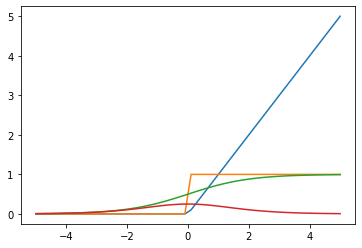

In [3]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_d(x):
    return sigmoid(x) * (1-sigmoid(x))
        
def relu(x):
    result =  x if x > 0 else 0
    return result

def relu_d(x):
    result = 1 if x >= 0 else 0
    return result

# This function makes it simple and efficient to call a function for an entire array
def callOnArray(x, function):    
    if (isinstance(x, np.ndarray)):
        if (x.ndim == 1):
            return np.array(list(map(function,x)))
        else:
            return np.array([callOnArray(ai, function) for ai in x]) # if it has multiple dimensions
    if isinstance(x, int):
        return function(x)

# Quick test of the functions
x = np.linspace(-5,5,50)
y= callOnArray(x, relu)
plt.plot(x,y)
y_d = callOnArray(x, relu_d)
plt.plot(x,y_d)
y_s= callOnArray(x, sigmoid)
plt.plot(x,y_s)
y_s_d = callOnArray(x, sigmoid_d)
plt.plot(x,y_s_d) 

#### Test how multiplications work with numpy

In [4]:
d_cost_d_a = np.array([[1,2,3],[1,2,4]]) # dc_da 
d_a_d_z = np.array([[1,2,3]])   # da_dz

d_cost_d_z = d_cost_d_a * d_a_d_z
x =  np.array([[1,1],[2,2],[3,3]])

d = np.array( [delta*p for n in d_cost_d_z for delta, p in zip(n,x) ])
d = np.sum(d.reshape(len(d_cost_d_a),len(x),len(x[0])), axis = 1) # amount of neurons (len(self.weights)), datapoints, dimensionality 
d

array([[36, 36],
       [45, 45]])

#### The building blocks for a neural net
First, a one layer network is tested

In [5]:
class Layer:
    def __init__(self, input_size, neurons, learning_rate = 0.2, activationFunction = sigmoid, activationFunctionD = sigmoid_d):
        self.learning_rate = learning_rate
        self.input_size = input_size
        self.neurons = neurons
        self.weights = np.random.rand(neurons, input_size)*2 -1 # assign random values between -1 and 1
        self.biases = np.array([np.random.rand(neurons)]).T *2 -1 # make the array in an array a column vector
        
        self.activationFunction = activationFunction
        self.activationFunctionD = activationFunctionD        
        
    def calc(self, x):
        assert(len(x[0]) == self.weights.shape[1])         
        result = callOnArray(np.dot(self.weights, x.T) + self.biases, self.activationFunction).T
        return result
    
    def cost(self, x, y):
        y_pred = self.calc(x)
        return (y_pred - y) * ( y_pred - y)
    
    # This is the normal learning function for a one layer network
    def learnLastLayer(self,x, y):
        y_pred = self.calc(x)
        Dcost_Da = y_pred.T - y.T
        self.learn(x, Dcost_Da)
        return
    
    # The learning algorithm is expressed with the following terms:
    #    a: output of a neuron, z: input of a neuron
    #    Dcost_Da: partial derivative of the cost with respect to the output of the neurons
    #    Da_Dz   : partial derivative of the activationfunction with respect to the input of the neurons
    #    Dcost_Dz: partial derivative of the cost with respect to the input of the neurons
    #              -> also referred to as "Deltas" when used in backpropagation
    def learn(self, x, Dcost_Da):
        assert(len(x)>0)       
        Da_Dz = callOnArray(np.dot(self.weights, x.T) + self.biases, self.activationFunctionD)      
        self.deltas = Dcost_Da * Da_Dz  # save the deltas for the next layer
        Dcost_Dz = -self.deltas
        
        # Calculate the delta weights for every neuron, for every datapoint
        delta_w = np.array( [delta*p for n in Dcost_Dz for delta, p in zip(n,x) ])
        # Sum up the delta_w for all the datapoints to get the total delta_weight per neuron
        delta_weights = np.sum(delta_w.reshape(self.neurons,len(x),len(x[0])), axis = 1) * self.learning_rate # aantal neurons (len(self.weights, aantal datapoints, aantal dimensies 
        
        # similar for the biases
        delta_biases = np.sum(Dcost_Dz.reshape(self.neurons,len(x),1), axis = 1) * self.learning_rate
     
        self.weights += delta_weights
        self.biases  += delta_biases        
        return
    
    
    #---------------- The below functions are necessary for a multilayer network ---------------------
    def learnLayer(self, x, delta_next_layer, weights_next_layer):
        Dcost_Da = np.dot(delta_next_layer.T, weights_next_layer).T
        self.learn(x, Dcost_Da)
        return
    
    # Should only be called if the layer has learnt and calculated the deltas for the 
    def getDeltas(self):
        return self.deltas
    
    def getWeights(self):
        return self.weights
        
        
    # For debugging purposes, prints weights and biases
    def show(self):
        string = ""
        biases = " "        
        for i in range(self.neurons):
            string +="[ "            
            for w in self.weights[i]:
                string+= "{0:4f} ".format(w)
                biases += "     "
            string += "]    "
            biases += "{0:4f}       ".format(self.biases[i][0])
        print(string)
        print(biases)  
        return
        

#### Make a test setup
Two outputs are generated, this is how the neural nets should classify after training \
Yellow = 1 \
Purple = 0

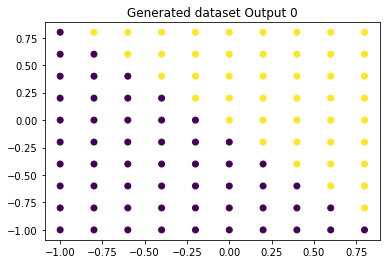

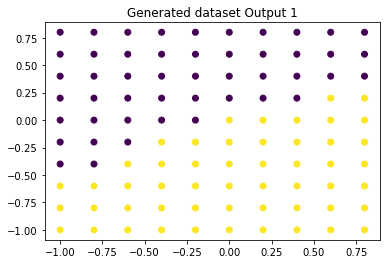

In [6]:
# perceptron = NeuralNet()
n = 10
X = np.zeros((n*n,2))
Y = np.zeros((n*n,2))
for i in range(n):
    for j in range(n):
        index = i*n + j
        X[index] = np.array([i * 0.2-1, j * 0.2 - 1])        
        Y[index] = np.array([1 if X[index][0] + X[index][1] >= 0 else 0,  1 if X[index][0] - 2*X[index][1] >= 0 else 0])

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.33, random_state=42)

# This is what a perfect classification looks like
plotresult2(X,Y, "Generated dataset")

#### Test a single layer with 1 neuron

Before training:


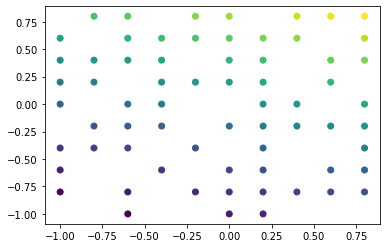

In [7]:
layer = Layer(2,1)

print("Before training:")
y_pred = layer.calc(X_train)
fig = plt.subplots()  
plotresult(X_train, y_pred)

train_cost = []
test_cost = []
for i in range(500):      
    cost= layer.cost(X_train, y_train[:,0][...,None]).mean()
    train_cost.append(cost)
    cost2= layer.cost(X_test, y_test[:,0][...,None]).mean()
    test_cost.append(cost2)
    layer.learnLastLayer(X_train, y_train[:,0])

After training:


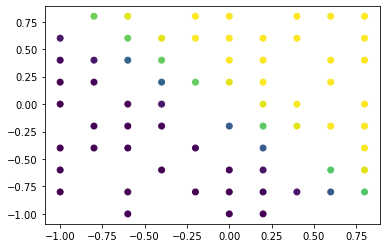

In [8]:
print("After training:")
y_pred = layer.calc(X_train)
fig = plt.subplots()  
plotresult(X_train, y_pred[:,0])

#### The training and test cost

final test cost:  0.018372751192962236


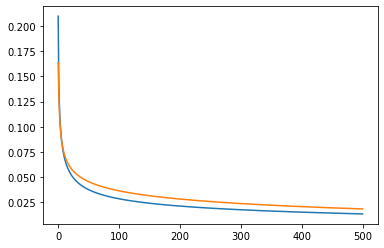

In [9]:
plt.plot(train_cost)
plt.plot(test_cost) # orange
print("final test cost: " ,test_cost[-1])

#### Comparing sigmoid (previous) to relu 

In [10]:
layer = Layer(2,1, learning_rate = 0.1, activationFunction = relu, activationFunctionD = relu_d)

train_cost = []
test_cost = []
for i in range(100):      
    cost= layer.cost(X_train, y_train[:,0])[0].mean()
    train_cost.append(cost)
    cost2= layer.cost(X_test, y_test[:,0])[0].mean()
    test_cost.append(cost2)
    y_pred = layer.calc(X_train)[0]
    layer.learnLastLayer(X_train, y_train[:,0])

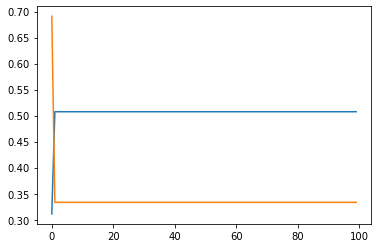

In [11]:
plt.plot(train_cost)
plt.plot(test_cost) # orange

Because the relu function and the derivative of the relu function are zero for x<0, it is possible for the algorithm to get stuck. If wx + b drops below 0 for all the training data, changes to the weights and biases become impossible and the algorithm no longer learns.

#### Simple function to test networks:

In [12]:
def testNetwork(network, learnfunction, X, Y, iterations = 500):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.33, random_state=42)

    print("Before training: (weights & biases)")
    network.show()
    y_pred = network.calc(X_train)
    plotresult2(X_train, y_pred, title = "Before training")    

    train_cost = []
    test_cost = []
    for i in range(iterations):      
        cost= network.cost(X_train, y_train).mean( axis = 0)
        train_cost.append(cost)
        cost2= network.cost(X_test, y_test).mean(axis = 0)
        test_cost.append(cost2)        
        learnfunction(X_train, y_train)
        
    print("After training:")
    network.show()
    y_pred = network.calc(X_train)
    plotresult2(X_train, y_pred, title =  "After training")
    
    # Plot 
    train_cost = np.array(train_cost).mean(axis = 1)    
    plt.subplots()
    plt.plot(train_cost)
    test_cost = np.array(test_cost).mean(axis = 1)
    plt.plot(test_cost)
    plt.title("Train (blue) & test (orange) cost")
    print("final test cost: ", test_cost[-1].mean())

### Multiple outputs

Before training: (weights & biases)
[ 0.415746 -0.111012 ]    [ -0.732448 0.563629 ]    
           -0.228814                 0.220607       
After training:
[ 7.546071 7.705561 ]    [ 4.293319 -9.089996 ]    
           0.898073                 -0.206705       
final test cost:  0.02449303817158966


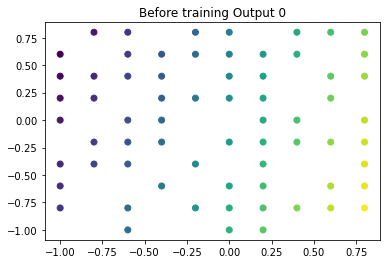

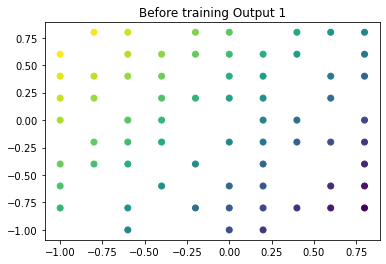

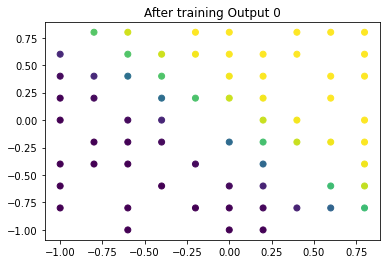

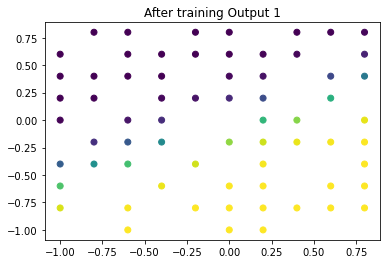

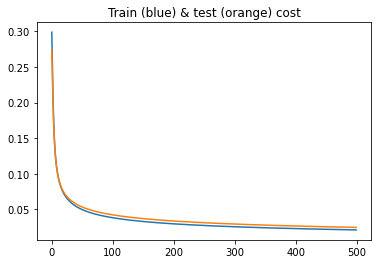

In [13]:
layer = Layer(2,2, learning_rate = 0.1)
testNetwork(layer, layer.learnLastLayer, X, Y )

### Adding a second layer

In [14]:
class NeuralNet:
    def __init__(self, n_input, n_output, hidden = [5], learning_rate = 0.1, activationFunction = sigmoid, activationFunctionD = sigmoid_d):
        self.activationFunction = activationFunction
        self.activationFunctionD = activationFunctionD
        self.learning_rate = learning_rate
        
        # Initiate layers
        self.layers = []
        for n in hidden:
            self.layers.append(Layer(n_input,n, learning_rate = self.learning_rate, activationFunction = self.activationFunction, activationFunctionD = self.activationFunctionD))
            n_input = n
        self.layers.append(Layer(n_input, n_output, learning_rate = self.learning_rate, activationFunction = self.activationFunction, activationFunctionD = self.activationFunctionD))
        
    def calc(self, x):
        for layer in self.layers:
            x = layer.calc(x)
        return x
    
    def cost(self, x, y):
        y_pred = self.calc(x)
        return (y_pred - y)*(y_pred - y)
    
    
    def learn(self, x, y):
        x_layers = [x]
        
        # Calculate the output for every layer and pass it to the next layer
        for layer in self.layers:
            x_layers.append(layer.calc(x_layers[-1]))
        
        # The last layer can be learned simply by comparing the output to the desired output
        last_layer = self.layers[-1]
        last_layer.learnLastLayer(x_layers[-2], y)
        
        # The other layers use the deltas and weights of the next layer
        deltas = last_layer.getDeltas()
        weights = last_layer.getWeights()
        for layer, xj in zip(reversed(self.layers[0:-1]), reversed(x_layers[0:-2])):
            layer.learnLayer(xj, deltas, weights)
            deltas = layer.getDeltas()
            weights = layer.getWeights()
        return
    
    def show(self):
        print("---------------------------------------------------------------------------")
        for layer in self.layers:
            layer.show()
        return

Before training: (weights & biases)
---------------------------------------------------------------------------
[ 0.603318 0.324432 ]    [ -0.516950 0.118828 ]    [ 0.031482 0.704640 ]    
           -0.929884                 -0.265998                 -0.219980       
[ -0.221842 -0.164531 0.981569 ]    [ -0.077008 0.845649 -0.208212 ]    [ 0.322885 -0.691917 -0.236775 ]    
                0.016451                      -0.463832                      0.062111       
[ -0.401356 -0.443408 0.784284 ]    [ 0.353268 0.429085 0.886291 ]    
                -0.527716                      0.338607       
After training:
---------------------------------------------------------------------------
[ 2.834015 2.352524 ]    [ -4.778302 -4.722133 ]    [ -3.104670 6.297258 ]    
           1.154937                 -0.210767                 0.044079       
[ -2.048619 -1.528201 7.014455 ]    [ -1.605587 4.334956 -1.771718 ]    [ 3.629826 -5.495938 -0.319801 ]    
                -1.495551            

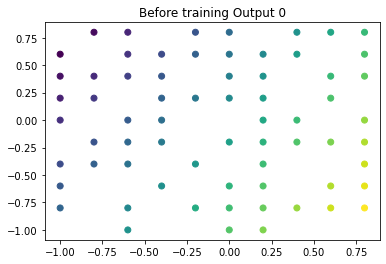

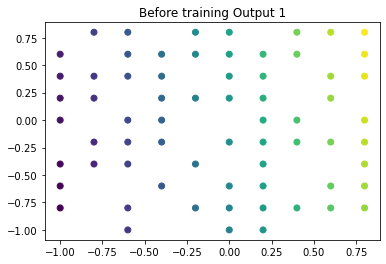

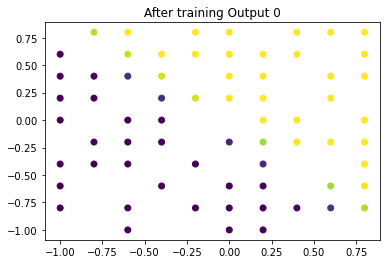

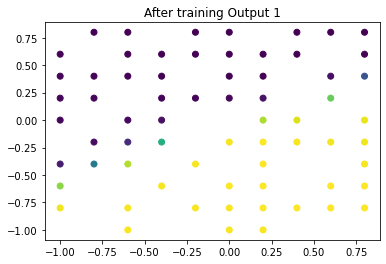

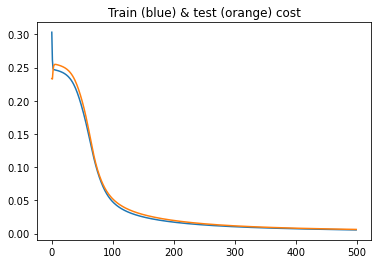

In [15]:
nn = NeuralNet(2,2, hidden = [3,3], learning_rate = 0.1)
testNetwork(nn, nn.learn, X, Y )

#### Results
As expected, adding more layers requires more training to converge. However, the final cost is lower than for a simpler network.

#### Test library file

Before training: (weights & biases)
---------------------------------------------------------------------------
[ 0.851799 0.087045 ]    [ 0.675805 0.531756 ]    [ -0.104506 -0.466235 ]    
           0.996392                 -0.979699                 -0.428904       
[ -0.401552 -0.822329 0.936849 ]    [ 0.958195 0.084458 -0.122768 ]    [ 0.060042 0.158920 0.582323 ]    
                0.142065                      -0.305994                      -0.717016       
[ -0.094999 -0.591720 -0.475618 ]    [ -0.794601 0.657057 0.311460 ]    
                -0.555850                      -0.617731       
After training:
---------------------------------------------------------------------------
[ 3.367892 -6.415394 ]    [ 3.091097 3.150657 ]    [ -4.626841 -4.525201 ]    
           -0.144379                 0.011958                 -0.543938       
[ -1.344826 -3.183371 3.598767 ]    [ 6.887099 -1.078435 -0.095651 ]    [ 1.208266 -3.487039 5.430631 ]    
                -0.347179           

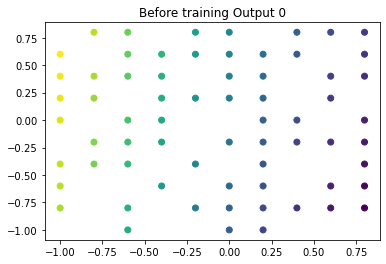

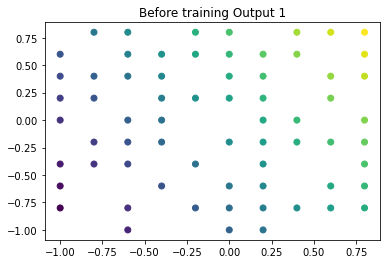

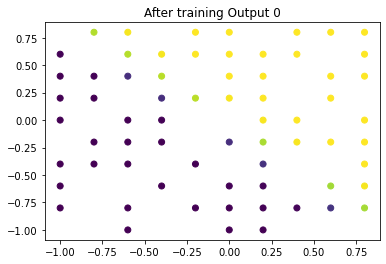

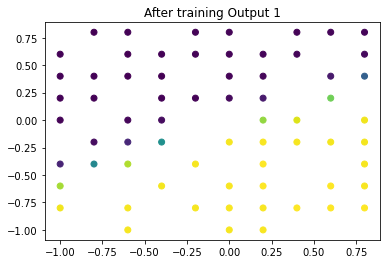

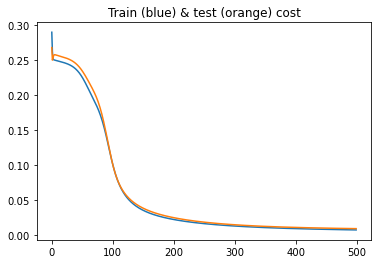

In [16]:
import MyNeuralNet

nn = MyNeuralNet.NeuralNet(2,2, hidden = [3,3], learning_rate = 0.1)

testNetwork(nn, nn.learn, X, Y )

Possible additions:  
- Add generalization
- Additional layer at the end without activation function for universal function approximation